In [2]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import shutil
#from evaluation_functions import *
from functions_ import *
from plotting import *
from Bio import SeqIO
import matplotlib.patches as patches
from collections import Counter


In [3]:
### define the necessary variables

base_dir = os.getcwd() 

catch_left = ''
catch_right = ''

Barcodes = {"BC1_fwd": "CCC", 
            "BC1_rev" : "CCC", 
            "BC2_fwd":	"AAA",
            "BC2_rev":	"AAA", 
            "BC3_fwd":	"TTT",
            "BC3_rev":	"TTT",}

Primer_seq = {"_fwd": "cgccgCATGGAAGCGAT".upper(),
              "_rev":"cgcacgCGGTTATCCATCG".upper()}

Primer_out_of_triplets = {"_fwd": 0, 
                          "_rev": 2}
amplicon_seq = "cgccgCATGGAAGCGATTAACGAAAGCagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcCTGCATCCGCCGATGGATAACCGcgtgcg".upper() #cg

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}


ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

In [4]:

### make sure to run the second code chunk before this one, since the primer dict could have been updated during analysis of the repeated seq run of S2, S3
remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-',] 
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/']

ref_gene = amplicon_seq

variant = "R36"
used_BCs = ["BC1", "BC2", "BC3"]

filter_for_n_mut =False# True
read_len_treshold = None#(40,40)

## variant 4
a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

all_reads, all_ids = demultiplex_reads(a_seq, b_seq, ref_gene = ref_gene ,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = used_BCs, Sections = [""], max_mismatch_primerseq = 5, filter_for_n_mut = filter_for_n_mut, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,  read_len_treshold= read_len_treshold, Primer_out_of_triplets= Primer_out_of_triplets, cut_primer_start=True, cut_BC_seq=True)


#### settings
amplicon_DNA = amplicon_seq[:-2]
amplicon_AA = translate_dna2aa(amplicon_DNA)

### set parameters
base_dir = os.getcwd()
name = variant
FigFolder =f"{base_dir}/output/{name}/R1-R2"
use_rev_read = True
use_forward_read = True
arbitrary_cutoff_a = False
arbitrary_cutoff_b = False

if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)

total reads 85274
[3, 5, 6, 11, 12, 14, 18, 20, 23, 24]
41699
2324 b reads are empty
702 a reads are empty
34446 forward reads with matching BC and primer seq
15012 reads with index swapping
BC1  34446 reads before filtering
################# Done: BC1 
################# Done: BC1
[0, 1, 2, 4, 7, 8, 9, 10, 15, 17]
26509
1951 b reads are empty
209 a reads are empty
21158 forward reads with matching BC and primer seq
13269 reads with index swapping
BC2  21158 reads before filtering
################# Done: BC2 
################# Done: BC2
[13, 16, 19, 21, 22, 31, 41, 44, 56, 71]
11759
852 b reads are empty
85 a reads are empty
8452 forward reads with matching BC and primer seq
7610 reads with index swapping
BC3  8452 reads before filtering
################# Done: BC3 
################# Done: BC3


In [5]:
insertions = [#"X",
   #"GG",
   # "PP",
    #"GXG"
   "GGSG",
   "GSGG",
   "GPPG",
   "GSGSG",
   "GPPPG",
   "GSGGSG",
   "GPPPPG"] + ["G"+x+"G" for x in ecoli_pref.keys()] # + "GXG" AAs ## !!! "X" insertions are not included here, also "PP" and "GG" are not included here


insertion_codons = {insertion : "".join([ecoli_pref[Aa] for Aa in insertion]) for insertion in insertions }
subst = {Aa: "".join([ecoli_pref[a] for a in Aa]) for Aa in ["GG", "PP"]}
deletions = {"del1": "-"*9, # deletion of SG + deletion of the AA in front = total of 9 nucleotides
             "del2": "-"*12,
             "del3": "-"*15,}

In [6]:
intended_changes = list(insertion_codons.values()) + list(subst.values())+ list(ecoli_pref.values())

In [60]:
Barcode = "BC2"
read_direction = "R1" 

adaptor_left = ""#Barcodes[Barcode+ "_fwd"] ## for a_seq
seq_before_linker = "TTAACGAAAGC"
seq_after_linker = "TTAGCCACAA"
total_seq = "cgccgCATGGAAGCGATTAACGAAAGC".upper()#"GCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCT" # sequence from primer until linker
linker_seq = "AGCGGT" 
reads = all_reads[f"{Barcode}__R1"]

linker_vars, linker_vars_perc, linker_AA_perc = get_linker_variants(reads=reads, seq_before_linker=seq_before_linker, seq_after_linker=seq_after_linker, total_seq=total_seq,  wt_linker=linker_seq, include_changes_after_linker = True, include_deletions = True, intended_changes = intended_changes, combine_other = False, adaptor_left=adaptor_left, filter_treshold = 0.05, rev_reads=False)

total reads 21158
reads with target sequence 13300


In [58]:
read_direction = "R2"
adaptor_left = ""
seq_before_linker = "GCGGCCAAA"
seq_after_linker ="CTGCATCC"
total_seq = "CTGCATCCGCCGATGGATAACCGcgtgc".upper()
linker_seq = "GGGAGC" 
reads = [dna_rev_comp(read) for read in all_reads[f"{Barcode}__R2"]]

linker_vars, linker_vars_perc, linker_AA_perc = get_linker_variants(reads=reads, seq_before_linker=seq_before_linker, seq_after_linker=seq_after_linker, total_seq=total_seq,  wt_linker=linker_seq, include_changes_after_linker = True, include_deletions = True, intended_changes = intended_changes, combine_other = False, adaptor_left=adaptor_left, filter_treshold = 0.05, rev_reads=True)

total reads 8452
reads with target sequence 5389


In [46]:
linker_vars_perc

{'wt': 81.07389686337055,
 'CGT': 6.158071947545632,
 'AAA': 3.437887648413964,
 'AGC': 1.1607301080985293,
 'GCG': 1.1518695729222044,
 'CAG': 0.9657983342193869,
 'AAC': 0.6556796030480241,
 'GGC': 0.5404926457558037,
 'GGCCGTGGC': 0.49618996987418035,
 'CAT': 0.4607478291688818,
 'other_AAAAAA': 0.45188729399255717,
 'ACC': 0.36328194222931065,
 'del-6': 0.34556087187666135,
 'TGC': 0.29239766081871343,
 'GTG': 0.2835371256423888,
 'GGCGCGGGC': 0.2303739145844409,
 'CTG': 0.20379230905546694,
 'GGCAGCGGCGGC': 0.177210703526493,
 'GGCAGCGGC': 0.1594896331738437,
 'ATG': 0.13290802764486975,
 'GGCAAAGGC': 0.13290802764486975,
 'GGCTGCGGC': 0.12404749246854509,
 'GGCGGC': 0.12404749246854509,
 'GGCGTGGGC': 0.12404749246854509,
 'ATT': 0.09746588693957114,
 'GGCCAGGGC': 0.07974481658692185}

In [61]:
## exclude wt 
linker_vars_perc = {seq: count for seq,count in linker_vars_perc.items() if seq != "wt"}
for change in intended_changes + ["del-9", "del-12", "del-15"]:
    print(change in linker_vars_perc.keys()) if change not in linker_vars_perc.keys() else None
    if change not in linker_vars_perc.keys():
        linker_vars_perc[change] = 0
        
linker_AA_perc  = {seq: count for seq,count in linker_AA_perc.items() if seq != "wt"}
for change in intended_changes + ["del-9", "del-12", "del-15"]:
    change = translate_dna2aa(change) if change[0] in ["A","C","G","T"] else change
    print(change in linker_AA_perc.keys()) if change not in linker_AA_perc.keys() else None
    if change not in linker_AA_perc.keys():
        linker_AA_perc[change] = 0

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


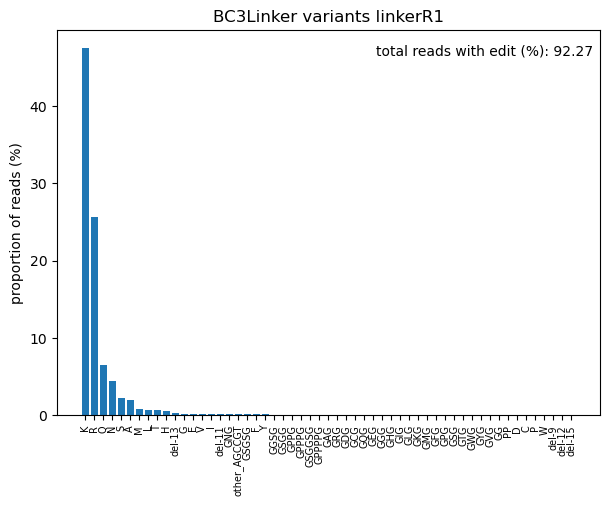

In [57]:
plt.figure(figsize=(7,5))
plt.bar(list(linker_AA_perc.keys()), list(linker_AA_perc.values()))
plt.title(Barcode + "Linker variants linker" + read_direction)
plt.xticks(rotation=90, fontsize = 7)
plt.ylabel("proportion of reads (%)")  
#plt.ylim(0,1.0)
## add text at top right corner
plt.text(0.58, 0.83, "total reads with edit (%): "+str(round(sum(linker_AA_perc.values()),2)), fontsize = 10, transform=plt.gcf().transFigure)
#plt.savefig("output/RL1/linker_R2_indel_Nt_freq.pdf", bbox_inches = "tight")    
plt.show()

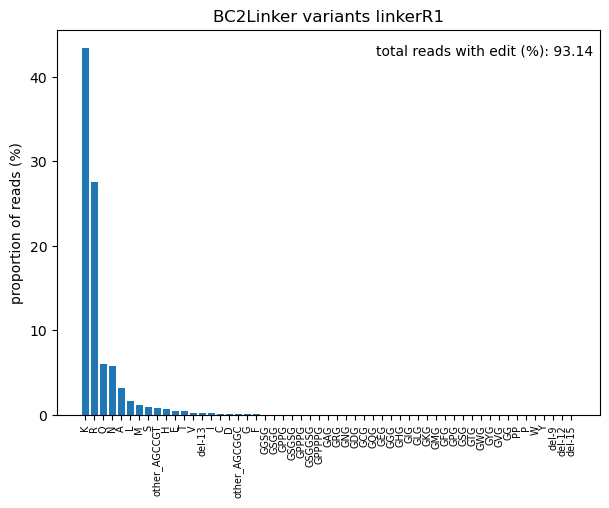

In [62]:
plt.figure(figsize=(7,5))
plt.bar(list(linker_AA_perc.keys()), list(linker_AA_perc.values()))
plt.title(Barcode + "Linker variants linker" + read_direction)
plt.xticks(rotation=90, fontsize = 7)
plt.ylabel("proportion of reads (%)")  
#plt.ylim(0,1.0)
## add text at top right corner
plt.text(0.58, 0.83, "total reads with edit (%): "+str(round(sum(linker_AA_perc.values()),2)), fontsize = 10, transform=plt.gcf().transFigure)
#plt.savefig("output/RL1/linker_R2_indel_Nt_freq.pdf", bbox_inches = "tight")    
plt.show()

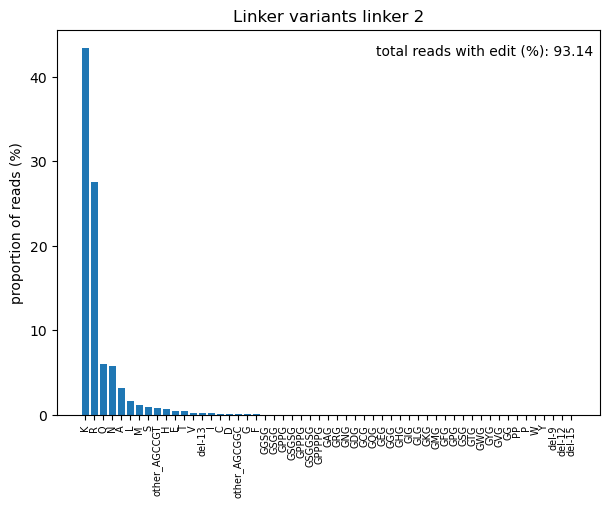

In [44]:
plt.figure(figsize=(7,5))
plt.bar(list(linker_AA_perc.keys()), list(linker_AA_perc.values()))
plt.title(Barcode + "Linker variants linker" + read_direction)
plt.xticks(rotation=90, fontsize = 7)
plt.ylabel("proportion of reads (%)")  
#plt.ylim(0,1.0)
## add text at top right corner
plt.text(0.58, 0.83, "total reads with edit (%): "+str(round(sum(linker_AA_perc.values()),2)), fontsize = 10, transform=plt.gcf().transFigure)
#plt.savefig("output/RL1/linker_R2_indel_Nt_freq.pdf", bbox_inches = "tight")    
plt.show()